In [1]:
import pandas as pd

metadata_path = "/kaggle/input/abo-small/metadata/images.csv"
df = pd.read_csv(metadata_path)
df.head()
print("Total images:", len(df))
#print(df["image_id"].dtype)
#print(df["image_id"].apply(type).value_counts())


Total images: 398212


🖼️ Image ID: 010-mllS7JL
📏 Dimensions: 106x106
📂 Path: /kaggle/input/abo-small/small/14/14fe8812.jpg


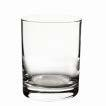

🖼️ Image ID: 01dkn0Gyx0L
📏 Dimensions: 122x122
📂 Path: /kaggle/input/abo-small/small/da/daab0cad.jpg


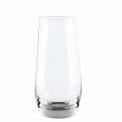

🖼️ Image ID: 01sUPg0387L
📏 Dimensions: 111x111
📂 Path: /kaggle/input/abo-small/small/d2/d2daaae9.jpg


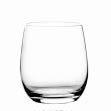

🖼️ Image ID: 1168jc-5r1L
📏 Dimensions: 186x186
📂 Path: /kaggle/input/abo-small/small/3a/3a4e88e6.jpg


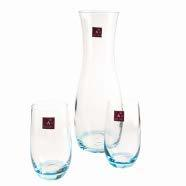

🖼️ Image ID: 11RUV5Fs65L
📏 Dimensions: 30x500
📂 Path: /kaggle/input/abo-small/small/d9/d91ab9cf.jpg


In [2]:
import os
from PIL import Image
from IPython.display import display

# Base directory where the actual image folders are located
image_base_path = "/kaggle/input/abo-small/small"

# Sample a few rows to visualize
sample_df = df.head()

for _, row in sample_df.iterrows():
    image_path = os.path.join(image_base_path, row["path"])
    print(f"🖼️ Image ID: {row['image_id']}")
    print(f"📏 Dimensions: {row['height']}x{row['width']}")
    print(f"📂 Path: {image_path}")
    
    try:
        img = Image.open(image_path).convert("RGB")
        display(img)
    except Exception as e:
        print("⚠️ Could not load image:", e)


In [3]:
vqa_dataset_path = "/kaggle/input/vqadataset/VQADataset.csv"
vqa_df = pd.read_csv(vqa_dataset_path)
vqa_df.head()
print("Total questions:", len(vqa_df))
#print(df["image_id"].dtype)
#print(df["image_id"].apply(type).value_counts())
print(vqa_df.columns)
print(vqa_df.isnull().sum())
vqa_df = vqa_df.dropna(subset=['answer'])
print(f"After dropping missing answers: {len(vqa_df)} questions")




Total questions: 64406
Index(['image_id', 'question', 'answer', 'difficulty'], dtype='object')
image_id       0
question       0
answer        12
difficulty     0
dtype: int64
After dropping missing answers: 64394 questions


In [4]:
# Create a lookup dictionary from the image metadata
id_to_path_full = dict(zip(df["image_id"], df["path"]))

# Filter only those image_ids that are actually in the VQA dataset
vqa_image_ids = set(vqa_df["image_id"])
vqa_id_to_path = {img_id: id_to_path_full[img_id] for img_id in vqa_image_ids if img_id in id_to_path_full}

print(f"✅ Mapped {len(vqa_id_to_path)} image_ids from VQA dataset to image paths.")


✅ Mapped 20344 image_ids from VQA dataset to image paths.


In [5]:
!pip install accelerate

In [6]:
!pip install -U bitsandbytes


In [7]:
from transformers import ViltProcessor, ViltForQuestionAnswering
import torch

# Load processor and model
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
base_model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = base_model.to(device)
base_model.eval()


2025-05-15 14:52:19.424202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747320739.448202     141 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747320739.455452     141 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=76

In [8]:
from peft import PeftModel
from accelerate import Accelerator
accelerator = Accelerator()

# Load the fine-tuned LoRA adapter on top
model = PeftModel.from_pretrained(base_model, "/kaggle/input/fine-tuned-vilt")

# Move model to appropriate device (GPU or CPU)
model = accelerator.prepare(model)
model.eval()

PeftModel(
  (base_model): LoraModel(
    (model): ViltForQuestionAnswering(
      (vilt): ViltModel(
        (embeddings): ViltEmbeddings(
          (text_embeddings): TextEmbeddings(
            (word_embeddings): Embedding(30522, 768)
            (position_embeddings): Embedding(40, 768)
            (token_type_embeddings): Embedding(2, 768)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (patch_embeddings): ViltPatchEmbeddings(
            (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
          )
          (token_type_embeddings): Embedding(2, 768)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): ViltEncoder(
          (layer): ModuleList(
            (0-11): 12 x ViltLayer(
              (attention): ViltAttention(
                (attention): ViltSelfAttention(
                  (query): lora.Linear(
                    (ba

In [9]:
from PIL import Image
import os

data = []
image_base_path = "/kaggle/input/abo-small/small"

for idx, row in vqa_df.iterrows():
    img_id = row['image_id']
    question = row['question']
    answer = row['answer']

    # get image path from id-to-path mapping
    if img_id not in vqa_id_to_path:
        continue
    img_rel_path = vqa_id_to_path[img_id]
    img_path = os.path.join(image_base_path, img_rel_path)

    try:
        image = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"Skipping image {img_path} due to error: {e}")
        continue
    
    data.append({
        "image": image,
        "question": question,
        "answer": answer
    })

print(f"Loaded {len(data)} samples")


Loaded 64394 samples


In [18]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(vqa_df, test_size=0.2, random_state=118)

In [19]:
!pip install bert-score rouge-score nltk

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Then, move inputs to device as well:
encoding = processor(image, question, return_tensors="pt").to(device)

# or if encoding is a dict of tensors:
encoding = {k: v.to(device) for k, v in encoding.items()}

output = model(**encoding)


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

encoding = processor(image, question, return_tensors="pt")
encoding = {k: v.to(device) for k, v in encoding.items()}

output = model(**encoding)



In [22]:
print("Encoding device:", {k: v.device for k, v in encoding.items()})
print("Model device:", next(model.parameters()).device)

output = model(**encoding)
print("Output:", output)


Encoding device: {'input_ids': device(type='cuda', index=0), 'token_type_ids': device(type='cuda', index=0), 'attention_mask': device(type='cuda', index=0), 'pixel_values': device(type='cuda', index=0), 'pixel_mask': device(type='cuda', index=0)}
Model device: cuda:0
Output: SequenceClassifierOutput(loss=None, logits=tensor([[-14.3183, -12.4024,  -6.2981,  ..., -17.9698, -16.4451, -17.0541]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [23]:
logits = output.logits
pred_id = logits.argmax(-1).item()
print("Predicted class id:", pred_id)


Predicted class id: 4


In [24]:
import torch.nn.functional as F
probs = F.softmax(logits, dim=-1)
print("Probabilities:", probs)


Probabilities: tensor([[7.4830e-08, 5.0831e-07, 2.2763e-04,  ..., 1.9420e-09, 8.9212e-09,
         4.8521e-09]], device='cuda:0')


In [32]:
!pip install evaluate


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 5.3 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [35]:
from tqdm import tqdm
import contextlib
import io

from evaluate import load
metric = load("accuracy")

import warnings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
generated_answers = []
ground_truth_answers = []
skip_logs = []
skipped = 0
def evaluate_and_log(preds, gts, step):
    correct = sum([p == gt for p, gt in zip(preds, gts)])
    accuracy = correct / len(preds)
    print(f"[Step {step}] Accuracy so far: {accuracy:.4f}")




for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    question = row["question"]
    gt_answer = str(row["answer"]).strip().lower()
    image_id = row["image_id"]

    image_rel_path = vqa_id_to_path.get(image_id)
    if image_rel_path is None:
        skip_logs.append(f"[SKIP] No path for image_id {image_id} (index {idx})")
        skipped += 1
        continue

    full_path = os.path.join(image_base_path, image_rel_path)
    if not os.path.exists(full_path):
        skip_logs.append(f"[SKIP] Image not found: {full_path}")
        skipped += 1
        continue

    try:
        image = Image.open(full_path).convert("RGB")
    except Exception as e:
        skip_logs.append(f"[SKIP] Failed to load image: {full_path} | Error: {e}")
        skipped += 1
        continue

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
            encoding = processor(image, question, return_tensors="pt")
            # Move inputs to the same device as the model
            encoding = {k: v.to(device) for k, v in encoding.items()}

            # Forward pass
            output = model(**encoding)
            logits = output.logits
            pred_id = logits.argmax(-1).item()
            pred_answer = model.config.id2label[pred_id].strip().lower()

    generated_answers.append(pred_answer)
    ground_truth_answers.append(gt_answer)

    if len(generated_answers) % 100 == 0:
        evaluate_and_log(generated_answers, ground_truth_answers, len(generated_answers))


  1%|          | 102/12879 [00:03<07:23, 28.80it/s]

[Step 100] Accuracy so far: 0.2700


  2%|▏         | 205/12879 [00:06<07:37, 27.71it/s]

[Step 200] Accuracy so far: 0.2900


  2%|▏         | 302/12879 [00:10<06:57, 30.14it/s]

[Step 300] Accuracy so far: 0.2867


  3%|▎         | 405/12879 [00:13<07:11, 28.93it/s]

[Step 400] Accuracy so far: 0.2775


  4%|▍         | 505/12879 [00:17<06:47, 30.39it/s]

[Step 500] Accuracy so far: 0.2580


  5%|▍         | 605/12879 [00:20<06:42, 30.51it/s]

[Step 600] Accuracy so far: 0.2550


  5%|▌         | 704/12879 [00:24<06:36, 30.68it/s]

[Step 700] Accuracy so far: 0.2557


  6%|▌         | 804/12879 [00:27<06:35, 30.51it/s]

[Step 800] Accuracy so far: 0.2437


  7%|▋         | 905/12879 [00:30<06:39, 29.95it/s]

[Step 900] Accuracy so far: 0.2544


  8%|▊         | 1005/12879 [00:34<06:49, 29.01it/s]

[Step 1000] Accuracy so far: 0.2560


  9%|▊         | 1106/12879 [00:37<06:27, 30.38it/s]

[Step 1100] Accuracy so far: 0.2509


  9%|▉         | 1203/12879 [00:40<06:38, 29.28it/s]

[Step 1200] Accuracy so far: 0.2542


 10%|█         | 1302/12879 [00:44<06:16, 30.79it/s]

[Step 1300] Accuracy so far: 0.2585


 11%|█         | 1403/12879 [00:47<06:49, 28.03it/s]

[Step 1400] Accuracy so far: 0.2557


 12%|█▏        | 1504/12879 [00:51<06:12, 30.57it/s]

[Step 1500] Accuracy so far: 0.2573


 12%|█▏        | 1603/12879 [00:54<06:00, 31.26it/s]

[Step 1600] Accuracy so far: 0.2569


 13%|█▎        | 1706/12879 [00:57<05:57, 31.26it/s]

[Step 1700] Accuracy so far: 0.2600


 14%|█▍        | 1804/12879 [01:01<05:56, 31.03it/s]

[Step 1800] Accuracy so far: 0.2589


 15%|█▍        | 1904/12879 [01:04<05:58, 30.59it/s]

[Step 1900] Accuracy so far: 0.2595


 16%|█▌        | 2005/12879 [01:07<05:58, 30.30it/s]

[Step 2000] Accuracy so far: 0.2655


 16%|█▋        | 2104/12879 [01:11<06:11, 29.01it/s]

[Step 2100] Accuracy so far: 0.2633


 17%|█▋        | 2204/12879 [01:14<06:08, 28.94it/s]

[Step 2200] Accuracy so far: 0.2623


 18%|█▊        | 2302/12879 [01:17<06:23, 27.61it/s]

[Step 2300] Accuracy so far: 0.2596


 19%|█▊        | 2405/12879 [01:21<05:32, 31.51it/s]

[Step 2400] Accuracy so far: 0.2567


 19%|█▉        | 2506/12879 [01:24<05:40, 30.45it/s]

[Step 2500] Accuracy so far: 0.2592


 20%|██        | 2606/12879 [01:28<05:24, 31.62it/s]

[Step 2600] Accuracy so far: 0.2581


 21%|██        | 2703/12879 [01:31<05:28, 30.93it/s]

[Step 2700] Accuracy so far: 0.2589


 22%|██▏       | 2803/12879 [01:34<05:30, 30.44it/s]

[Step 2800] Accuracy so far: 0.2596


 23%|██▎       | 2903/12879 [01:38<05:44, 28.94it/s]

[Step 2900] Accuracy so far: 0.2624


 23%|██▎       | 3005/12879 [01:41<05:40, 28.99it/s]

[Step 3000] Accuracy so far: 0.2623


 24%|██▍       | 3102/12879 [01:44<05:24, 30.14it/s]

[Step 3100] Accuracy so far: 0.2616


 25%|██▍       | 3206/12879 [01:48<05:05, 31.67it/s]

[Step 3200] Accuracy so far: 0.2631


 26%|██▌       | 3303/12879 [01:51<05:12, 30.63it/s]

[Step 3300] Accuracy so far: 0.2630


 26%|██▋       | 3405/12879 [01:54<04:59, 31.63it/s]

[Step 3400] Accuracy so far: 0.2606


 27%|██▋       | 3504/12879 [01:57<04:53, 31.92it/s]

[Step 3500] Accuracy so far: 0.2614


 28%|██▊       | 3603/12879 [02:01<05:08, 30.12it/s]

[Step 3600] Accuracy so far: 0.2603


 29%|██▉       | 3705/12879 [02:04<05:12, 29.31it/s]

[Step 3700] Accuracy so far: 0.2597


 30%|██▉       | 3805/12879 [02:07<04:49, 31.37it/s]

[Step 3800] Accuracy so far: 0.2589


 30%|███       | 3906/12879 [02:10<04:47, 31.24it/s]

[Step 3900] Accuracy so far: 0.2582


 31%|███       | 4005/12879 [02:14<04:47, 30.84it/s]

[Step 4000] Accuracy so far: 0.2577


 32%|███▏      | 4104/12879 [02:17<04:45, 30.78it/s]

[Step 4100] Accuracy so far: 0.2588


 33%|███▎      | 4206/12879 [02:20<04:42, 30.66it/s]

[Step 4200] Accuracy so far: 0.2581


 33%|███▎      | 4304/12879 [02:24<04:38, 30.81it/s]

[Step 4300] Accuracy so far: 0.2584


 34%|███▍      | 4404/12879 [02:27<04:35, 30.77it/s]

[Step 4400] Accuracy so far: 0.2577


 35%|███▍      | 4505/12879 [02:30<05:02, 27.69it/s]

[Step 4500] Accuracy so far: 0.2558


 36%|███▌      | 4604/12879 [02:34<04:54, 28.13it/s]

[Step 4600] Accuracy so far: 0.2561


 37%|███▋      | 4703/12879 [02:37<04:55, 27.64it/s]

[Step 4700] Accuracy so far: 0.2564


 37%|███▋      | 4803/12879 [02:41<04:55, 27.29it/s]

[Step 4800] Accuracy so far: 0.2548


 38%|███▊      | 4905/12879 [02:45<05:01, 26.44it/s]

[Step 4900] Accuracy so far: 0.2545


 39%|███▉      | 5004/12879 [02:48<04:38, 28.30it/s]

[Step 5000] Accuracy so far: 0.2548


 40%|███▉      | 5103/12879 [02:52<04:37, 27.98it/s]

[Step 5100] Accuracy so far: 0.2555


 40%|████      | 5203/12879 [02:56<04:33, 28.06it/s]

[Step 5200] Accuracy so far: 0.2573


 41%|████      | 5303/12879 [02:59<04:08, 30.46it/s]

[Step 5300] Accuracy so far: 0.2558


 42%|████▏     | 5406/12879 [03:02<03:52, 32.09it/s]

[Step 5400] Accuracy so far: 0.2552


 43%|████▎     | 5505/12879 [03:06<03:54, 31.42it/s]

[Step 5500] Accuracy so far: 0.2549


 44%|████▎     | 5604/12879 [03:09<03:49, 31.76it/s]

[Step 5600] Accuracy so far: 0.2550


 44%|████▍     | 5706/12879 [03:12<03:43, 32.10it/s]

[Step 5700] Accuracy so far: 0.2549


 45%|████▌     | 5803/12879 [03:15<03:53, 30.33it/s]

[Step 5800] Accuracy so far: 0.2543


 46%|████▌     | 5905/12879 [03:19<03:47, 30.66it/s]

[Step 5900] Accuracy so far: 0.2536


 47%|████▋     | 6005/12879 [03:22<03:38, 31.43it/s]

[Step 6000] Accuracy so far: 0.2527


 47%|████▋     | 6105/12879 [03:26<03:54, 28.91it/s]

[Step 6100] Accuracy so far: 0.2521


 48%|████▊     | 6205/12879 [03:29<03:35, 30.97it/s]

[Step 6200] Accuracy so far: 0.2526


 49%|████▉     | 6305/12879 [03:32<03:32, 30.98it/s]

[Step 6300] Accuracy so far: 0.2516


 50%|████▉     | 6403/12879 [03:35<03:23, 31.86it/s]

[Step 6400] Accuracy so far: 0.2517


 51%|█████     | 6505/12879 [03:38<03:19, 31.89it/s]

[Step 6500] Accuracy so far: 0.2509


 51%|█████▏    | 6604/12879 [03:42<03:26, 30.43it/s]

[Step 6600] Accuracy so far: 0.2494


 52%|█████▏    | 6706/12879 [03:45<03:24, 30.20it/s]

[Step 6700] Accuracy so far: 0.2485


 53%|█████▎    | 6804/12879 [03:48<03:11, 31.65it/s]

[Step 6800] Accuracy so far: 0.2479


 54%|█████▎    | 6906/12879 [03:51<03:13, 30.94it/s]

[Step 6900] Accuracy so far: 0.2477


 54%|█████▍    | 7005/12879 [03:55<03:11, 30.67it/s]

[Step 7000] Accuracy so far: 0.2484


 55%|█████▌    | 7103/12879 [03:58<03:11, 30.13it/s]

[Step 7100] Accuracy so far: 0.2483


 56%|█████▌    | 7203/12879 [04:01<03:03, 30.99it/s]

[Step 7200] Accuracy so far: 0.2486


 57%|█████▋    | 7303/12879 [04:04<03:00, 30.84it/s]

[Step 7300] Accuracy so far: 0.2493


 57%|█████▋    | 7403/12879 [04:08<02:50, 32.09it/s]

[Step 7400] Accuracy so far: 0.2489


 58%|█████▊    | 7503/12879 [04:11<02:51, 31.33it/s]

[Step 7500] Accuracy so far: 0.2489


 59%|█████▉    | 7603/12879 [04:14<02:44, 32.05it/s]

[Step 7600] Accuracy so far: 0.2489


 60%|█████▉    | 7707/12879 [04:17<02:29, 34.57it/s]

[Step 7700] Accuracy so far: 0.2495


 61%|██████    | 7803/12879 [04:20<02:34, 32.82it/s]

[Step 7800] Accuracy so far: 0.2503


 61%|██████▏   | 7903/12879 [04:23<02:39, 31.14it/s]

[Step 7900] Accuracy so far: 0.2508


 62%|██████▏   | 8003/12879 [04:26<02:21, 34.40it/s]

[Step 8000] Accuracy so far: 0.2511


 63%|██████▎   | 8104/12879 [04:29<02:35, 30.79it/s]

[Step 8100] Accuracy so far: 0.2514


 64%|██████▎   | 8204/12879 [04:32<02:16, 34.22it/s]

[Step 8200] Accuracy so far: 0.2516


 64%|██████▍   | 8304/12879 [04:35<02:13, 34.39it/s]

[Step 8300] Accuracy so far: 0.2514


 65%|██████▌   | 8404/12879 [04:38<02:13, 33.42it/s]

[Step 8400] Accuracy so far: 0.2515


 66%|██████▌   | 8504/12879 [04:41<02:22, 30.78it/s]

[Step 8500] Accuracy so far: 0.2519


 67%|██████▋   | 8604/12879 [04:44<02:11, 32.57it/s]

[Step 8600] Accuracy so far: 0.2519


 68%|██████▊   | 8704/12879 [04:47<02:03, 33.71it/s]

[Step 8700] Accuracy so far: 0.2516


 68%|██████▊   | 8804/12879 [04:50<01:58, 34.39it/s]

[Step 8800] Accuracy so far: 0.2524


 69%|██████▉   | 8904/12879 [04:53<02:04, 31.98it/s]

[Step 8900] Accuracy so far: 0.2518


 70%|██████▉   | 9004/12879 [04:56<02:00, 32.03it/s]

[Step 9000] Accuracy so far: 0.2514


 71%|███████   | 9104/12879 [04:59<01:58, 31.94it/s]

[Step 9100] Accuracy so far: 0.2510


 71%|███████▏  | 9204/12879 [05:02<01:56, 31.58it/s]

[Step 9200] Accuracy so far: 0.2512


 72%|███████▏  | 9304/12879 [05:05<01:57, 30.41it/s]

[Step 9300] Accuracy so far: 0.2514


 73%|███████▎  | 9404/12879 [05:08<01:48, 32.04it/s]

[Step 9400] Accuracy so far: 0.2523


 74%|███████▍  | 9504/12879 [05:12<01:49, 30.91it/s]

[Step 9500] Accuracy so far: 0.2520


 75%|███████▍  | 9604/12879 [05:15<01:47, 30.39it/s]

[Step 9600] Accuracy so far: 0.2519


 75%|███████▌  | 9705/12879 [05:18<01:37, 32.56it/s]

[Step 9700] Accuracy so far: 0.2526


 76%|███████▌  | 9804/12879 [05:21<01:34, 32.40it/s]

[Step 9800] Accuracy so far: 0.2526


 77%|███████▋  | 9903/12879 [05:25<01:35, 31.19it/s]

[Step 9900] Accuracy so far: 0.2532


 78%|███████▊  | 10005/12879 [05:28<01:34, 30.43it/s]

[Step 10000] Accuracy so far: 0.2541


 78%|███████▊  | 10105/12879 [05:31<01:44, 26.43it/s]

[Step 10100] Accuracy so far: 0.2541


 79%|███████▉  | 10205/12879 [05:35<01:31, 29.31it/s]

[Step 10200] Accuracy so far: 0.2544


 80%|███████▉  | 10303/12879 [05:38<01:30, 28.43it/s]

[Step 10300] Accuracy so far: 0.2544


 81%|████████  | 10404/12879 [05:41<01:28, 28.04it/s]

[Step 10400] Accuracy so far: 0.2539


 82%|████████▏ | 10504/12879 [05:45<01:22, 28.85it/s]

[Step 10500] Accuracy so far: 0.2540


 82%|████████▏ | 10604/12879 [05:48<01:23, 27.31it/s]

[Step 10600] Accuracy so far: 0.2541


 83%|████████▎ | 10704/12879 [05:51<01:14, 29.08it/s]

[Step 10700] Accuracy so far: 0.2534


 84%|████████▍ | 10803/12879 [05:55<01:13, 28.07it/s]

[Step 10800] Accuracy so far: 0.2536


 85%|████████▍ | 10904/12879 [05:58<01:08, 28.78it/s]

[Step 10900] Accuracy so far: 0.2531


 85%|████████▌ | 11005/12879 [06:02<01:03, 29.28it/s]

[Step 11000] Accuracy so far: 0.2527


 86%|████████▌ | 11105/12879 [06:05<01:04, 27.31it/s]

[Step 11100] Accuracy so far: 0.2528


 87%|████████▋ | 11205/12879 [06:09<00:58, 28.43it/s]

[Step 11200] Accuracy so far: 0.2536


 88%|████████▊ | 11303/12879 [06:12<00:57, 27.30it/s]

[Step 11300] Accuracy so far: 0.2530


 89%|████████▊ | 11402/12879 [06:16<00:54, 27.25it/s]

[Step 11400] Accuracy so far: 0.2530


 89%|████████▉ | 11504/12879 [06:19<00:48, 28.59it/s]

[Step 11500] Accuracy so far: 0.2533


 90%|█████████ | 11603/12879 [06:22<00:43, 29.10it/s]

[Step 11600] Accuracy so far: 0.2534


 91%|█████████ | 11703/12879 [06:26<00:39, 29.62it/s]

[Step 11700] Accuracy so far: 0.2535


 92%|█████████▏| 11803/12879 [06:29<00:35, 30.71it/s]

[Step 11800] Accuracy so far: 0.2527


 92%|█████████▏| 11905/12879 [06:33<00:32, 30.09it/s]

[Step 11900] Accuracy so far: 0.2532


 93%|█████████▎| 12005/12879 [06:36<00:29, 29.92it/s]

[Step 12000] Accuracy so far: 0.2531


 94%|█████████▍| 12104/12879 [06:40<00:25, 30.05it/s]

[Step 12100] Accuracy so far: 0.2531


 95%|█████████▍| 12202/12879 [06:43<00:24, 27.99it/s]

[Step 12200] Accuracy so far: 0.2528


 96%|█████████▌| 12303/12879 [06:46<00:18, 30.62it/s]

[Step 12300] Accuracy so far: 0.2534


 96%|█████████▋| 12406/12879 [06:50<00:15, 30.66it/s]

[Step 12400] Accuracy so far: 0.2532


 97%|█████████▋| 12503/12879 [06:53<00:12, 29.15it/s]

[Step 12500] Accuracy so far: 0.2533


 98%|█████████▊| 12603/12879 [06:57<00:09, 30.21it/s]

[Step 12600] Accuracy so far: 0.2529


 99%|█████████▊| 12704/12879 [07:00<00:05, 29.84it/s]

[Step 12700] Accuracy so far: 0.2526


 99%|█████████▉| 12804/12879 [07:03<00:02, 29.37it/s]

[Step 12800] Accuracy so far: 0.2529


100%|██████████| 12879/12879 [07:06<00:00, 30.20it/s]


In [ ]:
import os
import warnings
import torch
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoProcessor, AutoModelForVisualQuestionAnswering
import contextlib
import io
import nltk
from sklearn.metrics import f1_score
from bert_score import score as bert_score
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction


nltk.download('punkt')

# Suppress warnings
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

eval_log_path = "vqa_eval_metrics.txt"
open(eval_log_path, "w").close()  # Clear file at start

# Metric utilities
def compute_f1(predictions, references):
    f1s = []
    for pred, gt in zip(predictions, references):
        pred_tokens = set(nltk.word_tokenize(pred))
        gt_tokens = set(nltk.word_tokenize(gt))
        common = pred_tokens.intersection(gt_tokens)
        if len(common) == 0:
            f1s.append(0.0)
        else:
            precision = len(common) / len(pred_tokens)
            recall = len(common) / len(gt_tokens)
            f1 = 2 * precision * recall / (precision + recall)
            f1s.append(f1)
    return sum(f1s) / len(f1s)

from sklearn.metrics import precision_score, recall_score

def evaluate_and_log(generated_answers, ground_truth_answers, step):
    # Exact Match
    exact_match_labels = [1 if pred == gt else 0 for pred, gt in zip(generated_answers, ground_truth_answers)]
    exact_accuracy = sum(exact_match_labels) / len(exact_match_labels) if exact_match_labels else 0.0
    exact_precision = precision_score([1]*len(exact_match_labels), exact_match_labels, zero_division=0)
    exact_recall = recall_score([1]*len(exact_match_labels), exact_match_labels, zero_division=0)
    exact_f1 = f1_score([1]*len(exact_match_labels), exact_match_labels, zero_division=0)

    # Substring Match
    substring_labels = [1 if gt in pred else 0 for pred, gt in zip(generated_answers, ground_truth_answers)]
    substring_accuracy = sum(substring_labels) / len(substring_labels) if substring_labels else 0.0
    substring_precision = precision_score([1]*len(substring_labels), substring_labels, zero_division=0)
    substring_recall = recall_score([1]*len(substring_labels), substring_labels, zero_division=0)
    substring_f1 = f1_score([1]*len(substring_labels), substring_labels, zero_division=0)

    # Token-level macro F1
    f1_macro = compute_f1(generated_answers, ground_truth_answers)

    # BERTScore
    P, R, F1 = bert_score(generated_answers, ground_truth_answers, lang="en", verbose=False)
    bertscore_f1 = F1.mean().item()

    # ROUGE-L
    rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_l_scores = [rouge.score(gt, pred)['rougeL'].fmeasure for pred, gt in zip(generated_answers, ground_truth_answers)]
    rouge_l_avg = sum(rouge_l_scores) / len(rouge_l_scores)

    # BLEU scores
    smoothie = SmoothingFunction().method4
    references = [[gt.split()] for gt in ground_truth_answers]
    candidates = [pred.split() for pred in generated_answers]
    bleu1 = corpus_bleu(references, candidates, weights=(1, 0, 0, 0), smoothing_function=smoothie)
    bleu2 = corpus_bleu(references, candidates, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
    bleu3 = corpus_bleu(references, candidates, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
    bleu4 = corpus_bleu(references, candidates, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

    # Logging
    with open(eval_log_path, "a") as f:
        f.write(f"\n--- Evaluation at step {step} ---\n")
        f.write(f"Exact Match Accuracy     : {exact_accuracy * 100:.2f}%\n")
        f.write(f"Exact Match Precision    : {exact_precision * 100:.2f}%\n")
        f.write(f"Exact Match Recall       : {exact_recall * 100:.2f}%\n")
        f.write(f"Exact Match F1           : {exact_f1 * 100:.2f}%\n")
        f.write(f"Substring Match Accuracy : {substring_accuracy * 100:.2f}%\n")
        f.write(f"Substring Match Precision: {substring_precision * 100:.2f}%\n")
        f.write(f"Substring Match Recall   : {substring_recall * 100:.2f}%\n")
        f.write(f"Substring Match F1       : {substring_f1 * 100:.2f}%\n")
        f.write(f"Token-level Macro F1     : {f1_macro * 100:.2f}%\n")
        f.write(f"BERTScore F1             : {bertscore_f1 * 100:.2f}%\n")
        f.write(f"ROUGE-L F1               : {rouge_l_avg * 100:.2f}%\n")
        f.write(f"BLEU-1                   : {bleu1 * 100:.2f}%\n")
        f.write(f"BLEU-2                   : {bleu2 * 100:.2f}%\n")
        f.write(f"BLEU-3                   : {bleu3 * 100:.2f}%\n")
        f.write(f"BLEU-4                   : {bleu4 * 100:.2f}%\n")



# Inference loop
generated_answers = []
ground_truth_answers = []
skipped = 0
skip_logs = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    question = row["question"]
    gt_answer = str(row["answer"]).strip().lower()
    image_id = row["image_id"]

    image_rel_path = vqa_id_to_path.get(image_id)
    if image_rel_path is None:
        skip_logs.append(f"[SKIP] No path for image_id {image_id} (index {idx})")
        skipped += 1
        continue

    full_path = os.path.join(image_base_path, image_rel_path)
    if not os.path.exists(full_path):
        skip_logs.append(f"[SKIP] Image not found: {full_path}")
        skipped += 1
        continue

    try:
        image = Image.open(full_path).convert("RGB")
    except Exception as e:
        skip_logs.append(f"[SKIP] Failed to load image: {full_path} | Error: {e}")
        skipped += 1
        continue

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
            # inputs = processor(images=image, text=question, return_tensors="pt").to("cuda", torch.float16)
            encoding = processor(image, question, return_tensors="pt")
            # forward pass
            output = model(**encoding)
            logits = output.logits
            pred_id = logits.argmax(-1).item()
            pred_answer = model.config.id2label[pred_id].strip().lower()
            # inputs = processor(images=image, text=question, return_tensors="pt")
            # inputs = {
            #     k: v.to(torch.float32) if v.dtype == torch.float16 else v
            #     for k, v in inputs.items()
            # }
            # output = model.generate(**inputs, max_new_tokens=10)
            # pred_answer = processor.decode(output[0], skip_special_tokens=True).strip().lower()

    generated_answers.append(pred_answer)
    ground_truth_answers.append(gt_answer)

    if len(generated_answers) % 100 == 0:
        evaluate_and_log(generated_answers, ground_truth_answers, len(generated_answers))

# Final evaluation
evaluate_and_log(generated_answers, ground_truth_answers, len(generated_answers))

# Print skip logs
if skip_logs:
    print("\n🛑 Skipped Entries:")
    for log in skip_logs:
        print(log)

# Save predictions
output_df = subset_vqa_df.iloc[:len(generated_answers)].copy()
output_df["predicted_answer"] = generated_answers
output_df.to_csv("BLIP2_VQA_Baseline_Predictions.csv", index=False)

In [ ]:
import torch
from transformers import ViltProcessor, ViltForQuestionAnswering
from PIL import Image
import json
from tqdm import tqdm
import nltk
nltk.download('punkt')


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model.to(device)
model.eval()


In [ ]:
import pandas as pd

df = pd.read_csv("/kaggle/input/vqadataset/VQADataset.csv")
print(df.head())
print(df.columns)


In [ ]:
import os

image_folder = "/kaggle/input/abo-small/small"
image_files = os.listdir(image_folder)
print(f"Total images found: {len(image_files)}")
print("Sample images:", image_files[:10])


In [ ]:
import os

image_folder = "/kaggle/input/abo-small/small"
entries = os.listdir(image_folder)
print(f"Entries in {image_folder}: {entries}")

for entry in entries:
    entry_path = os.path.join(image_folder, entry)
    print(f"{entry} is a directory? {os.path.isdir(entry_path)}")


In [ ]:
import os

sample_dirs = ['d8', '0d']  # sample subfolders

for subdir in sample_dirs:
    path = os.path.join("/kaggle/input/abo-small/small", subdir)
    files = os.listdir(path)
    print(f"Files in {subdir}: {files[:10]}")  # print first 10 files if many


In [ ]:
import os

def get_image_path(image_id):
    folder = image_id[:2]  # first two chars
    filename = f"{image_id}.jpg"
    return os.path.join("/kaggle/input/abo-small/small", folder, filename)


In [ ]:
import os

base_path = '/kaggle/input/abo-small/small'

folders = os.listdir(base_path)
print("Folders:", folders[:10])  # show first 10 folders

for folder in folders[:3]:  # check files in first 3 folders
    files = os.listdir(os.path.join(base_path, folder))
    print(f"Files in folder '{folder}':", files[:5])  # first 5 files


In [ ]:
valid_image_ids = []

for image_id in df['image_id'].unique()[:20]:  # check first 20 unique IDs
    folder = image_id[:2]
    filename = image_id + '.jpg'
    filepath = os.path.join(base_path, folder, filename)
    if os.path.exists(filepath):
        valid_image_ids.append(image_id)
    else:
        print(f"Missing: {filepath}")

print("Valid image IDs found:", valid_image_ids)


In [ ]:
import os

base_path_meta = '/kaggle/input/abo-product-metadata'

for root, dirs, files in os.walk(base_path_meta):
    print(f"Directory: {root}")
    print(f"Sample files: {files[:5]}")
    break  # just to print top level first



In [ ]:
import os

base_path_meta2 = '/kaggle/input/abo-small/metadata'

for root, dirs, files in os.walk(base_path_meta2):
    print(f"Directory: {root}")
    print(f"Sample files: {files[:5]}")
    break  # print top-level only


In [ ]:
import pandas as pd

images_csv_path = '/kaggle/input/abo-small/metadata/images.csv'
df_images = pd.read_csv(images_csv_path)
print(df_images.head())
print(f"Columns: {df_images.columns.tolist()}")


In [ ]:
def get_image_path(image_id):
    # Find the row with this image_id
    row = df_images[df_images['image_id'] == image_id]
    if row.empty:
        print(f"Image id {image_id} not found in metadata")
        return None
    relative_path = row.iloc[0]['path']  # e.g. '14/14fe8812.jpg'
    full_path = f"/kaggle/input/abo-small/small/{relative_path}"
    return full_path


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class VQADataset(Dataset):
    def __init__(self, csv_file, images_root, transform=None):
        import pandas as pd
        self.df = pd.read_csv(csv_file)
        print("CSV columns:", self.df.columns)   # <--- Add this line
        self.images_root = images_root
        self.transform = transform
    ...


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.images_root, row['path'])
        image = Image.open(img_path).convert("RGB")

        question = row['question']
        answer = row['answer'] if 'answer' in self.df.columns else None

        if self.transform:
            image = self.transform(image)

        sample = {
            'image': image,
            'question': question,
            'answer': answer,
        }
        return sample


In [ ]:
import pandas as pd

df = pd.read_csv(csv_path)
print(df.columns)
print(df.head(3))


In [ ]:
def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_id = row['image_id']
    subfolder = image_id[:2]  # first two characters of image_id
    img_filename = f"{image_id}.jpg"
    img_path = os.path.join(self.images_root, subfolder, img_filename)

    image = Image.open(img_path).convert("RGB")
    question = row['question']
    answer = row['answer'] if 'answer' in self.df.columns else None

    if self.transform:
        image = self.transform(image)

    sample = {
        'image': image,
        'question': question,
        'answer': answer,
    }
    return sample


In [ ]:
import os
import pandas as pd

base_dir = '/kaggle/input/abo-small'

for fname in os.listdir(base_dir):
    if fname.endswith('.csv'):
        print(f"CSV file: {fname}")
        df = pd.read_csv(os.path.join(base_dir, fname))
        print(df.columns)
        print(df.head(2))
        print()


In [ ]:
import pandas as pd

metadata_path = '/kaggle/input/abo-small/metadata/images.csv'
metadata_df = pd.read_csv(metadata_path)
print(metadata_df.head())
print(metadata_df.columns)


In [ ]:
from PIL import Image
from IPython.display import display
import os

root_image_dir = '/kaggle/input/abo-small/small'
img_rel_path = metadata_df.loc[0, 'path']
img_full_path = os.path.join(root_image_dir, img_rel_path)

image = Image.open(img_full_path)
display(image)  # This will render the image inline in the notebook


In [ ]:
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image

class VQADataset(Dataset):
    def __init__(self, images_csv, questions_csv, images_root, transform=None):
        self.images_df = pd.read_csv(images_csv)
        self.questions_df = pd.read_csv(questions_csv)
        
        # Merge questions with images on image_id
        self.data = pd.merge(self.questions_df, self.images_df, on='image_id', how='inner')
        
        self.images_root = images_root
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Load image
        img_path = f"{self.images_root}/{row['path']}"
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        question = row['question']
        answer = row['answer']
        
        return {
            'image': image,
            'question': question,
            'answer': answer,
        }


In [ ]:
import pandas as pd

csv_file = '/kaggle/input/vqadataset/VQADataset.csv'
df = pd.read_csv(csv_file)
print(df.columns)
print(df.head())


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

images_csv = '/kaggle/input/abo-small/metadata/images.csv'
questions_csv = '/kaggle/input/abo-small/metadata/questions.csv'  # update with your actual questions CSV path
images_root = '/kaggle/input/abo-small/small'

dataset = VQADataset(images_csv=images_csv, questions_csv=questions_csv, images_root=images_root, transform=transform)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

batch = next(iter(data_loader))
print(f"Batch images shape: {batch['image'].shape}")
print(f"Batch questions: {batch['question']}")
print(f"Batch answers: {batch['answer']}")


In [ ]:
from torch.utils.data import DataLoader

batch_size = 8

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Example: iterate through one batch
for batch in data_loader:
    images = batch['image']       # tensor of images (if transformed)
    questions = batch['question'] # list of questions (strings)
    answers = batch['answer']     # list of answers (strings or None)

    print(f"Batch images shape: {images.shape}")
    print(f"Batch questions: {questions[:2]}")
    print(f"Batch answers: {answers[:2]}")
    break


In [ ]:
from PIL import Image

# Example: Load images from a folder (change path as needed)
image_paths = ["/kaggle/input/vqadataset/sample1.jpg", "/kaggle/input/vqadataset/sample2.jpg"]  # your actual image paths here
images = [Image.open(path).convert("RGB") for path in image_paths]

# Example questions for each image
questions = [
    "What is in the image?",
    "How many objects are there?"
]


In [ ]:
# Cell 3: Prepare inputs and run the model (with device fix)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)  # Move model to the right device

for image, question in tqdm(zip(images, questions), total=len(images)):
    # Prepare inputs and move them to the correct device
    encoding = processor(image, question, return_tensors="pt")
    encoding = {k: v.to(device) for k, v in encoding.items()}  # Move inputs to device
    
    # Forward pass
    output = model(**encoding)
    
    logits = output.logits
    pred_id = logits.argmax(-1).item()
    pred_answer = model.config.id2label[pred_id]
    print(f"Question: {question}")
    print(f"Predicted answer: {pred_answer}")
